In [3]:
import numpy as np
import tensorflow as tf
import keras.api._v2.keras as K
from tqdm import trange
import keras
import matplotlib.pyplot as plt
#from IPython.core.display_functions import clear_output
from IPython.display import clear_output 
import random
import os
import tensorflow_probability as tfp
from sklearn.datasets import load_digits
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
NOISE_SHAPE = (128,)
BATCH_SIZE_DISC = 16
BATCH_SIZE_GEN = 16
SAMPLES = 16
STEPS = 1000000

In [5]:
(X_train, y_train) = load_digits(return_X_y=True)
X_train = (X_train.astype("float32").squeeze() > X_train.max()/2).astype(int).reshape((-1, 8, 8))

In [7]:
noise = K.layers.Input(shape=NOISE_SHAPE)
cls = K.layers.Input(shape=(10,))

x = K.layers.Concatenate()([noise, cls])
x = K.layers.Dense(256, activation="linear")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.relu)(x)

x = K.layers.Concatenate()([x, cls])
x = K.layers.Dense(256, activation="linear")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.relu)(x)

x = K.layers.Concatenate()([x, cls])
x = K.layers.Dense(256, activation="linear")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.relu)(x)

x = K.layers.Concatenate()([x, cls])
x = K.layers.Dense(256, activation="linear")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.relu)(x)

x = K.layers.Concatenate()([x, cls])
x = K.layers.Dense(256, activation="linear")(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.relu)(x)

x = K.layers.Dense(2*8*8)(x)
x = K.layers.Reshape([8,8,2])(x)
x = K.layers.Softmax(axis=-1)(x)
generator = K.Model(inputs=[noise, cls], outputs=[x])

Metal device set to: Apple M1 Max


2023-02-14 23:28:38.988318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-14 23:28:38.988350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
image = K.layers.Input(shape=X_train.shape[1:]+(1,))
x = K.layers.Conv2D(filters=64, kernel_size=(2,2), activation=tf.nn.leaky_relu, padding="SAME")(image)
x = K.layers.Conv2D(filters=64, kernel_size=(2,2), activation=tf.nn.leaky_relu, padding="SAME")(x)
x = K.layers.MaxPooling2D()(x)
x = K.layers.Conv2D(filters=64, kernel_size=(2,2), activation=tf.nn.leaky_relu, padding="SAME")(x)
x = K.layers.Conv2D(filters=64, kernel_size=(2,2), activation=tf.nn.leaky_relu, padding="SAME")(x)
x = K.layers.MaxPooling2D()(x)

cls = K.layers.Input(shape=(10,))
x = K.layers.Flatten()(x)
x = K.layers.Concatenate()([x, cls])
x = K.layers.Dense(256, activation=tf.nn.leaky_relu)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Dense(256, activation=tf.nn.leaky_relu)(x)
x = K.layers.Dense(1, activation="sigmoid")(x)
discriminator = K.Model(inputs=[image, cls], outputs=[x])

In [26]:
opt_disc = tf.keras.optimizers.legacy.Adam(1e-4)
opt_gen = tf.keras.optimizers.legacy.Adam(1e-4)

In [27]:
@tf.function
def train_step_disc(real_images, real_labels,  noise_disc):
    generator_labels = tf.squeeze(tf.one_hot(tfp.distributions.Categorical(probs=[.1]*10).sample(tf.shape(noise_disc)[0]), 10))
    generated_images_probs = generator([noise_disc, generator_labels], training=False)
    with tf.GradientTape(persistent=True) as tape:
        generated_images_probs = tf.linalg.normalize(generated_images_probs + 0.05, axis=-1, ord=1)[0]
        generated_images = tf.cast(tfp.distributions.Categorical(probs=generated_images_probs).sample(1)[...,None], tf.float32)[0]
        predictions_that_should_be_1 = discriminator([real_images, real_labels])
        predictions_that_should_be_0 = discriminator([generated_images, generator_labels])
        #BCE
        #loss_discriminator = tf.reduce_mean(-tf.math.log(1e-20 + predictions_that_should_be_1)) \
        #                     + tf.reduce_mean(-tf.math.log(1e-20 +  1 - predictions_that_should_be_0))
        #MAE
        loss_discriminator = tf.reduce_mean(tf.abs(predictions_that_should_be_1 - 0.9)) + \
                             tf.reduce_mean(tf.abs(predictions_that_should_be_0 - 0.1))
    with tf.device("/CPU:0"):
        grad_disc = tape.gradient(loss_discriminator, discriminator.trainable_weights)
    opt_disc.apply_gradients(zip(grad_disc, discriminator.trainable_weights))
@tf.function
def train_step_gen(noise_gen):
    generator_labels = tf.squeeze(tf.one_hot(tfp.distributions.Categorical(probs=[.1]*10).sample(tf.shape(noise_gen)[0]), 10))
    noise_gen = tf.repeat(noise_gen, SAMPLES, axis=0)
    generator_labels = tf.repeat(generator_labels, SAMPLES, axis=0)
    with tf.GradientTape(persistent=True) as tape:
        generated_images_probs = generator([noise_gen, generator_labels], training=True)
        generated_images_probs = tf.linalg.normalize(generated_images_probs + 0.05, axis=-1, ord=1)[0]
        generated_images = tf.cast(tfp.distributions.Categorical(probs=generated_images_probs).sample(1)[...,None], tf.float32)[0]
        predictions_that_should_be_0 = discriminator([
            generated_images, generator_labels
        ],training=False)
        rewards = -(tf.round(predictions_that_should_be_0[..., None, None])*2-1)
        log_pi_a_s = tf.math.log(tf.reduce_sum(tf.one_hot(tf.cast(tf.squeeze(generated_images), tf.int8), 2, axis=-1) * generated_images_probs, axis=-1, keepdims=True))
        loss_generator = tf.reduce_sum(
            log_pi_a_s * rewards
        )
    with tf.device("/CPU:0"):
        grad_gen = tape.gradient(loss_generator, generator.trainable_weights)
    opt_gen.apply_gradients(zip(grad_gen, generator.trainable_weights))
    return tf.reduce_mean(predictions_that_should_be_0)

In [28]:
MODELS_PREFIX = f"models/"
os.makedirs(MODELS_PREFIX, exist_ok=True)

2.3717682e-07


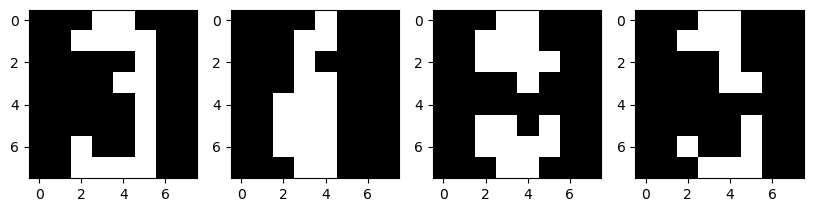

  0%|          | 1610/1000000 [02:00<16:05:55, 17.23it/s]

In [ ]:
latent_dim = NOISE_SHAPE[0]
mean_reward = 0
images_noise = np.random.normal(0, 1, (4, latent_dim))
images_labels = np.array([
    [1,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0],
])

rewards = []
for step in trange(STEPS):
    # Train the discriminator
    # Select a random batch of images
    current_indexes = np.random.randint(0, X_train.shape[0],BATCH_SIZE_DISC)
    real_images = X_train[current_indexes]
    real_labels = tf.one_hot(y_train[current_indexes], 10).numpy().squeeze()
    noise_disc = np.random.normal(0, 1, (BATCH_SIZE_DISC, latent_dim))
    noise_gen = np.random.normal(0, 1, (BATCH_SIZE_GEN, latent_dim))
    rewards.append(train_step(real_images, real_labels, noise_disc, noise_gen))
    N = 10
    if step % N == 0 :
        # clear output
        clear_output(wait=True)
        print(np.mean(rewards[-3:]))
        fig, axs = plt.subplots(1,4, figsize=(10,3))
        images = generator([images_noise, images_labels]).numpy().argmax(axis=-1)
        axs[0].imshow(images[0], cmap="gray")
        axs[1].imshow(images[1], cmap="gray")
        axs[2].imshow(images[2], cmap="gray")
        axs[3].imshow(images[3], cmap="gray")
        plt.show()
        # save
        discriminator.save_weights(f"{MODELS_PREFIX}/discriminator")
        generator.save_weights(f"{MODELS_PREFIX}/generator")
        print(generator([images_noise, images_labels]).numpy()[0,:10,:10,0].round(2))